In [12]:
import numpy as np
import os
import imageio
from skimage.transform import resize, rescale
import datetime
import os

import matplotlib.pyplot as plt

In [13]:
import tensorflow as tf
print(tf.__version__)
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
tf.random.set_seed(30)

2.7.0


In [14]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
num_classes = 5

In [15]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


In [16]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [17]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

In [18]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]  

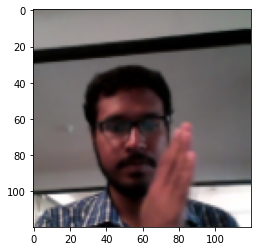

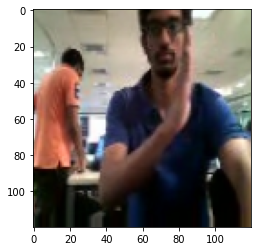

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)


image1 = imageio.imread("/home/datasets/Project_data/val/WIN_20180907_15_30_06_Pro_Right Swipe_new/WIN_20180907_15_30_06_Pro_00029.png")

image2 = imageio.imread("/home/datasets/Project_data/val/WIN_20180926_17_56_52_Pro_Right_Swipe_new/WIN_20180926_17_56_52_Pro_00029.png")

image1 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)                   
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)                 
plt.imshow(image2)
plt.show()


def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):

    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) 

        for batch in range(num_batches): 
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) 
            batch_labels = np.zeros((batch_size, 5))          

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes                    
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image                  
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image

                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [20]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2


In [21]:
from IPython.display import Markdown, display

def plot_history(history):
    display(Markdown("**Training Accuracy:** " + str(round(history.history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
    display(Markdown("**Validation Accuracy:** " + str(round(history.history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))
    
    #print("Training Accuracy:" + history.history['categorical_accuracy'][num_epochs-1])
    #print("Validation Accuracy:" + history.history['val_categorical_accuracy'][num_epochs-1])

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


In [22]:
from tensorflow.keras.optimizers import SGD

def conv3D_SGD(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=True) #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

### Iteration 1 :
- optimizer=SGD
- batch_size=10
- num_epochs=15
- height/width=100


In [23]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 100
width = 100

model = conv3D_SGD(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 10
# num_frames per video = 30
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_6 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                            

In [24]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [14]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/15


2024-09-09 10:33:50.772004: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.6188 - categorical_accuracy: 0.3952
Epoch 00001: val_loss improved from inf to 68.66106, saving model to model_conv3D_2_2024-09-0910_33_45.292922/model-00001-1.61882-0.39517-68.66106-0.23000.h5
67/67 [==============================] - 155s 2s/step - loss: 1.6188 - categorical_accuracy: 0.3952 - val_loss: 68.6611 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.4333 - categorical_accuracy: 0.4600
Epoch 00002: val_loss improved from 68.66106 to 2.95529, saving model to model_conv3D_2_2024-09-0910_33_45.292922/model-00002-1.43332-0.46003-2.95529-0.31000.h5
67/67 [==============================] - 153s 2s/step - loss: 1.4333 - categorical_accuracy: 0.4600 - val_loss: 2.9553 - val_categorical_accuracy: 0.3100 - lr: 0.0100
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 1.1811 - categorical_accuracy: 0.5370
Epoch 00003: val_loss improved from 2.9

**Training Accuracy:** 0.8%

**Validation Accuracy:** 0.73%

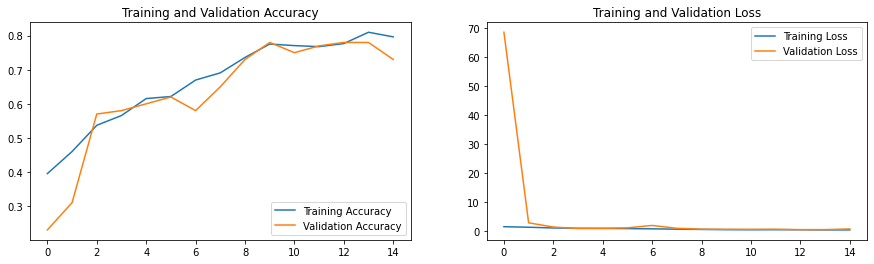

In [15]:
plot_history(history)

### Iteration 2 :
- optimizer=Adam
- batch_size=10
- num_epochs=15
- height/width=100

In [26]:
from tensorflow.keras.optimizers import Adam

def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

In [17]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 100
width = 100

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 10
# num_frames per video = 30
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_7 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                            

In [18]:
callbacks_list = model_callbacks("model_conv3D_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [19]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 1.6065 - categorical_accuracy: 0.4284
Epoch 00001: val_loss improved from inf to 1.58548, saving model to model_conv3D_1_2024-09-0910_33_45.292922/model-00001-1.60646-0.42836-1.58548-0.30000.h5
67/67 [==============================] - 154s 2s/step - loss: 1.6065 - categorical_accuracy: 0.4284 - val_loss: 1.5855 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.2035 - categorical_accuracy: 0.5415
Epoch 00002: val_loss did not improve from 1.58548
67/67 [==============================] - 154s 2s/step - loss: 1.2035 - categorical_accuracy: 0.5415 - val_loss: 2.9616 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 1.0020 - categorical_accuracy: 0.6003
Epoch 00003: val_loss did not improve from 1.58548
67/67 [==============================] - 154s 2s/step - loss: 1.0020 - categorical_accurac

**Training Accuracy:** 0.85%

**Validation Accuracy:** 0.79%

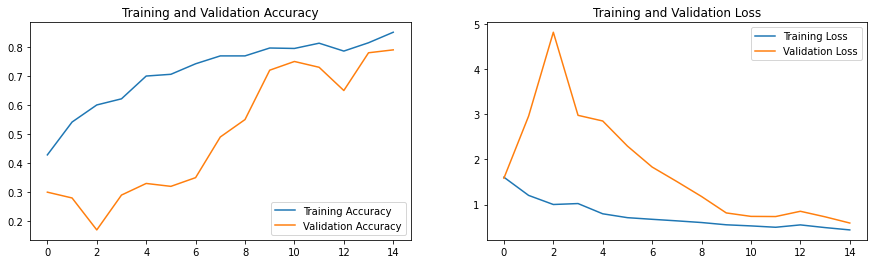

In [20]:
plot_history(history)

As you can see, the training and validation accuracy improved with adam. So, for the rest of the experiements we will continue with Adam optimiser

### Iteration 3 :
- optimizer=Adam
- batch_size=10
- num_epochs=25
- height/width=100

In [21]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 100
width = 100

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_14 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                            

In [22]:
callbacks_list = model_callbacks("model_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [23]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.5335 - categorical_accuracy: 0.4329
Epoch 00001: val_loss improved from inf to 2.62270, saving model to model_conv3D_1_2024-09-0910_33_45.292922/model-00001-1.53353-0.43288-2.62270-0.32000.h5
67/67 [==============================] - 191s 3s/step - loss: 1.5335 - categorical_accuracy: 0.4329 - val_loss: 2.6227 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.0840 - categorical_accuracy: 0.5596
Epoch 00002: val_loss did not improve from 2.62270
67/67 [==============================] - 157s 2s/step - loss: 1.0840 - categorical_accuracy: 0.5596 - val_loss: 5.0417 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 1.0157 - categorical_accuracy: 0.6063
Epoch 00003: val_loss improved from 2.62270 to 2.58958, saving model to model_conv3D_1_2024-09-0910_33_45.292922/model-00003-1.01569-0.60633-

**Training Accuracy:** 0.92%

**Validation Accuracy:** 0.87%

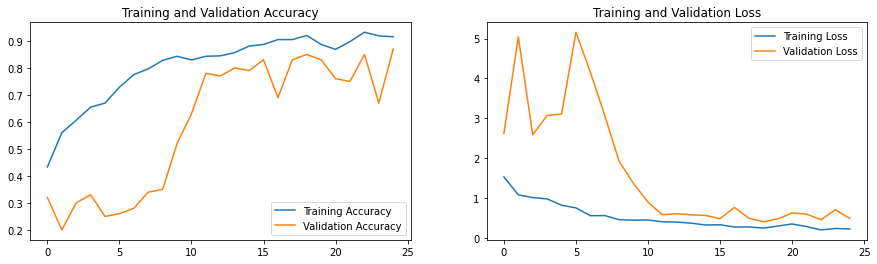

In [24]:
plot_history(history)

By increasing epoch to 25, the training accuracy improved from 86 to 92%

### Iteration 4 :
- optimizer=Adam
- batch_size=8
- num_epochs=25
- height/width=100

In [25]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 8  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 100
width = 100

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 25
# batch size = 8
# num_frames per video = 30
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_21 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                             

In [26]:
callbacks_list = model_callbacks("model_conv3D_4")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [27]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.5782 - categorical_accuracy: 0.4404
Epoch 00001: val_loss improved from inf to 3.36468, saving model to model_conv3D_1_2024-09-0910_33_45.292922/model-00001-1.57824-0.44042-3.36468-0.16000.h5
83/83 [==============================] - 153s 2s/step - loss: 1.5782 - categorical_accuracy: 0.4404 - val_loss: 3.3647 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.1828 - categorical_accuracy: 0.5445
Epoch 00002: val_loss improved from 3.36468 to 3.01794, saving model to model_conv3D_1_2024-09-0910_33_45.292922/model-00002-1.18285-0.54449-3.01794-0.24000.h5
83/83 [==============================] - 152s 2s/step - loss: 1.1828 - categorical_accuracy: 0.5445 - val_loss: 3.0179 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 1.0367 - categorical_accuracy: 0.6018
Epoch 00003: val_loss did not im

**Training Accuracy:** 0.96%

**Validation Accuracy:** 0.78%

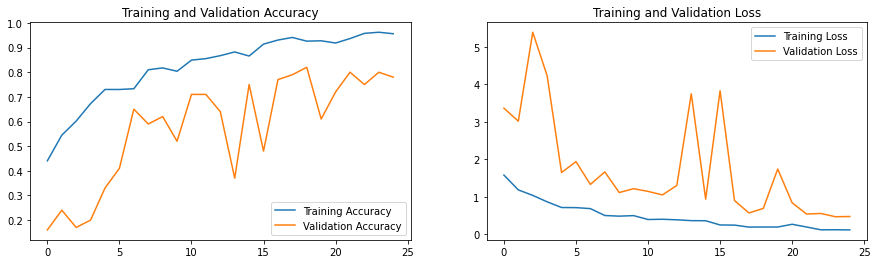

In [28]:
plot_history(history)

### Iteration 5 :
- optimizer=Adam
- batch_size=8
- num_epochs=25
- height/width=120

In [28]:
callbacks_list = model_callbacks("model_conv3D_5")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [27]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 8  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 25
# batch size = 8
# num_frames per video = 30
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_13 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                             

In [29]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/25


2024-09-09 16:37:38.058354: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


83/83 [==============================] - ETA: 0s - loss: 1.7092 - categorical_accuracy: 0.3695
Epoch 00001: val_loss improved from inf to 5.29438, saving model to model_conv3D_1_2024-09-0916_35_40.932810/model-00001-1.70922-0.36953-5.29438-0.19000.h5
83/83 [==============================] - 162s 2s/step - loss: 1.7092 - categorical_accuracy: 0.3695 - val_loss: 5.2944 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.4607 - categorical_accuracy: 0.4404
Epoch 00002: val_loss improved from 5.29438 to 4.57238, saving model to model_conv3D_1_2024-09-0916_35_40.932810/model-00002-1.46071-0.44042-4.57238-0.16000.h5
83/83 [==============================] - 168s 2s/step - loss: 1.4607 - categorical_accuracy: 0.4404 - val_loss: 4.5724 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 1.2478 - categorical_accuracy: 0.5113
Epoch 00003: val_loss did not improve from 

**Training Accuracy:** 0.89%

**Validation Accuracy:** 0.81%

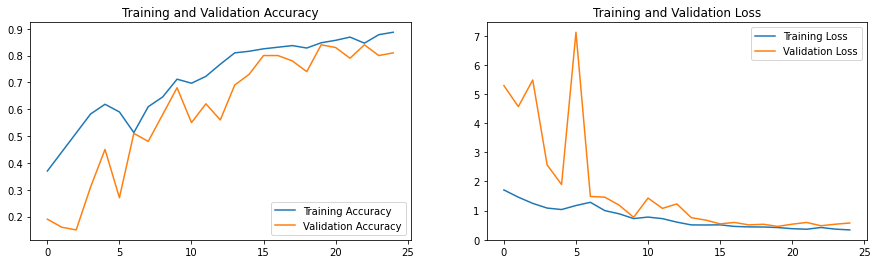

In [30]:
plot_history(history)

### Iteration 6 :
- optimizer=Adam
- batch_size=10
- num_epochs=35
- height/width=120

In [33]:
num_epochs = 35
print ('# epochs =', num_epochs)
batch_size = 8  
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 35
# batch size = 8
# num_frames per video = 30
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                             

In [34]:
callbacks_list = model_callbacks("model_conv3D_6")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [35]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/35
83/83 [==============================] - ETA: 0s - loss: 1.5968 - categorical_accuracy: 0.4178
Epoch 00001: val_loss improved from inf to 5.02973, saving model to model_conv3D_6_2024-09-0916_35_40.932810/model-00001-1.59678-0.41780-5.02973-0.16000.h5
83/83 [==============================] - 159s 2s/step - loss: 1.5968 - categorical_accuracy: 0.4178 - val_loss: 5.0297 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/35
83/83 [==============================] - ETA: 0s - loss: 1.2380 - categorical_accuracy: 0.5158
Epoch 00002: val_loss improved from 5.02973 to 2.75930, saving model to model_conv3D_6_2024-09-0916_35_40.932810/model-00002-1.23802-0.51584-2.75930-0.18000.h5
83/83 [==============================] - 157s 2s/step - loss: 1.2380 - categorical_accuracy: 0.5158 - val_loss: 2.7593 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/35
83/83 [==============================] - ETA: 0s - loss: 1.2278 - categorical_accuracy: 0.5083
Epoch 00003: val_loss did not im

**Training Accuracy:** 0.97%

**Validation Accuracy:** 0.81%

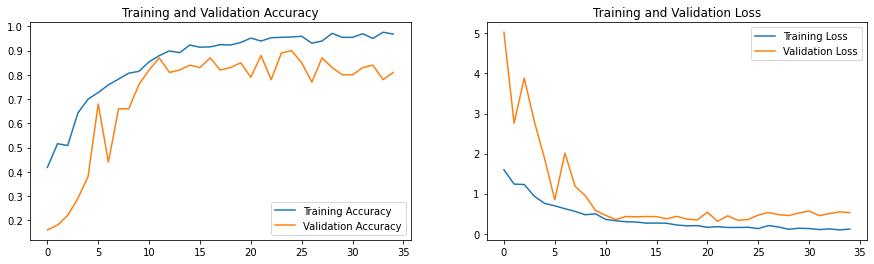

In [36]:
plot_history(history)

### Iteration 7 :
- optimizer=Adam
- batch_size=10
- num_epochs=35
- height/width=100

In [39]:
num_epochs = 35
print ('# epochs =', num_epochs)
batch_size = 10 
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 100
width = 100

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 35
# batch size = 10
# num_frames per video = 30
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_27 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                            

In [40]:
callbacks_list = model_callbacks("model_conv3D_6")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [41]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/35
67/67 [==============================] - ETA: 0s - loss: 1.6132 - categorical_accuracy: 0.4163
Epoch 00001: val_loss improved from inf to 3.11286, saving model to model_conv3D_6_2024-09-0916_35_40.932810/model-00001-1.61316-0.41629-3.11286-0.23000.h5
67/67 [==============================] - 158s 2s/step - loss: 1.6132 - categorical_accuracy: 0.4163 - val_loss: 3.1129 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/35
67/67 [==============================] - ETA: 0s - loss: 1.2263 - categorical_accuracy: 0.5309
Epoch 00002: val_loss did not improve from 3.11286
67/67 [==============================] - 153s 2s/step - loss: 1.2263 - categorical_accuracy: 0.5309 - val_loss: 4.7203 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/35
67/67 [==============================] - ETA: 0s - loss: 1.1353 - categorical_accuracy: 0.5882
Epoch 00003: val_loss did not improve from 3.11286
67/67 [==============================] - 156s 2s/step - loss: 1.1353 - categorical_accurac

**Training Accuracy:** 0.97%

**Validation Accuracy:** 0.84%

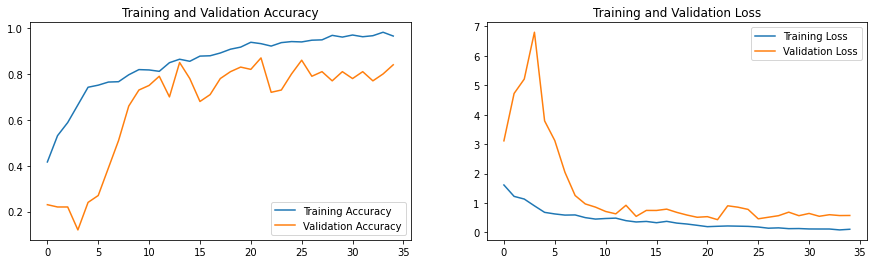

In [42]:
plot_history(history)

In [43]:
model.save('my_model.h5')